In [17]:
import pandas as pd
from pandas import DataFrame
from matplotlib import image
import matplotlib.pyplot as plt
from numpy import float32, zeros
from os.path import basename, join
import os
from matplotlib.pyplot import figure, imread, get_cmap
from random import sample, seed

In [2]:
DATA_PATH             = 'data_samples/'
TRAIN_PATH            = join(DATA_PATH,'train')
TRAIN_CSV_PATH        = join(DATA_PATH,'train.csv')

# Dataframe with the medatada of the train sample

Every row correspond to a cell marked in one of the train images


id - unique identifier for object

annotation - run length encoded pixels for the identified neuronal cell

width - source image width

height - source image height

cell_type - the cell line

plate_time - time plate was created

sample_date - date sample was created

sample_id - sample identifier

elapsed_timedelta - time since first image taken of sample

In [3]:
train_df = pd.read_csv(TRAIN_CSV_PATH)
train_df.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


# The types of neuronal cells are the following:

In [4]:
train_df['cell_type'].unique()

array(['shsy5y', 'astro', 'cort'], dtype=object)

Text(0.5, 1.0, 'Cell Types')

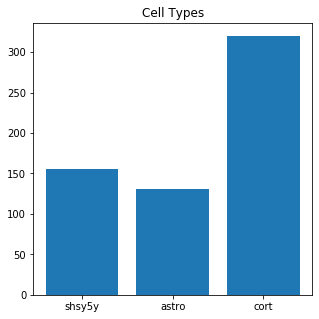

In [5]:
cell_types   = {}
for id,row in train_df.groupby(['id']):
    cell_type = row.cell_type.unique()[0]
    if not cell_type in cell_types:
        cell_types[cell_type]=[]
    cell_types[cell_type].append(id)
 
stats = {}
for cell_type,ids in cell_types.items():
    stats[cell_type] = len(ids)
fig = figure(figsize=(5,5))   
ax  = fig.subplots()
ax.bar(stats.keys(),stats.values())
ax.set_title('Cell Types')

There is a total of 606 images, the distribution of cell types across images is represented above.

The annotation colomn works like that:

In order to reduce the submission file size, our metric uses run-length encoding on the pixel values. Instead of submitting an exhaustive list of indices for your segmentation, you will submit pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels .

# Image Sample

First of all let's show a sample image from the train set

In this competition we have to detect and delineate distinc objects of interest in biological images depicting neuronal cell types commonly used in the study of neurological disorders. More specifically, we use phase contrast microscopy images to train and test models for instance segmentation of neuronal cells.

The neuroblastoma cell line SH-SY5Y consistently exhibits the lowest precision scores. This could be because neuronal cells have a very unique, irregular and concave morphology associated with them, making them challenging to segment with commonly used mask heads.

![Sample](data_samples/train/01ae5a43a2ab.png)

## Let's plot some examples of the annotated images

In [6]:
def get_cell_type(id, target_data):
    return target_data[target_data.id==id].cell_type.unique()[0]


def get_mask(template,annotation):
    img = zeros((template.shape[0] * template.shape[1], 1), dtype=float32)
    for pos,count in annotation.item():
        for i in range(count):
            img[pos-1+i] = 1
    return img.reshape((template.shape[0], template.shape[1]))


def read_and_display(id):
    image_file_name      = join(TRAIN_PATH,f'{id}.png')
    img                  = imread(image_file_name)
    mask                 = get_mask(img,df_targets.loc[df_targets.id==id]['annotations'])
    fig                  = figure(figsize=(20,20))
    ax                   = fig.subplots(ncols=2)
    ax[0].imshow(img, 
              cmap   = get_cmap('seismic'),
              origin = 'upper',
              vmax   = img.max(),
              vmin   = img.min())
    ax[0].set_title(f'{id}, cell type {get_cell_type(id, train_df)}')
    ax[1].imshow(mask, 
              cmap   = get_cmap('seismic'),
              origin = 'upper',
              vmax   = mask.max(),
              vmin   = mask.min())
    
def accumulate(id,annotation):
    def flatten(xss):
        return [x for xs in xss for x in xs]
    def parse(annot):
        xs = [int(x) for x in annot.split()]
        return [(xs[i],xs[i+1]) for i in range(0,len(xs),2)]
 
    return (id,sorted(flatten([parse(a) for a in annotation])))

accumulated_data = [accumulate(id,row.annotation) for id,row in train_df.groupby(['id'])]
df_targets       = DataFrame(list(zip([id for id,_ in accumulated_data],
                                     [a for _,a in accumulated_data])),
                    columns=['id','annotations'])

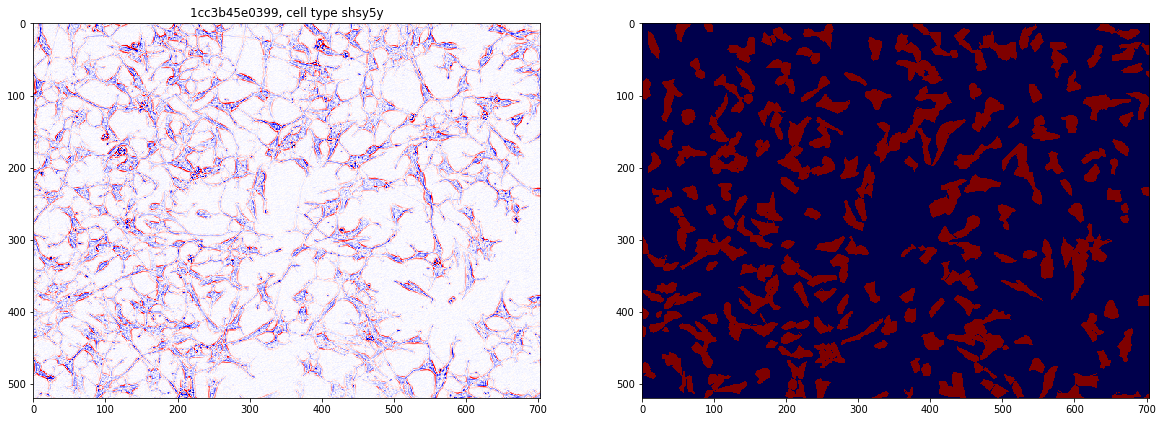

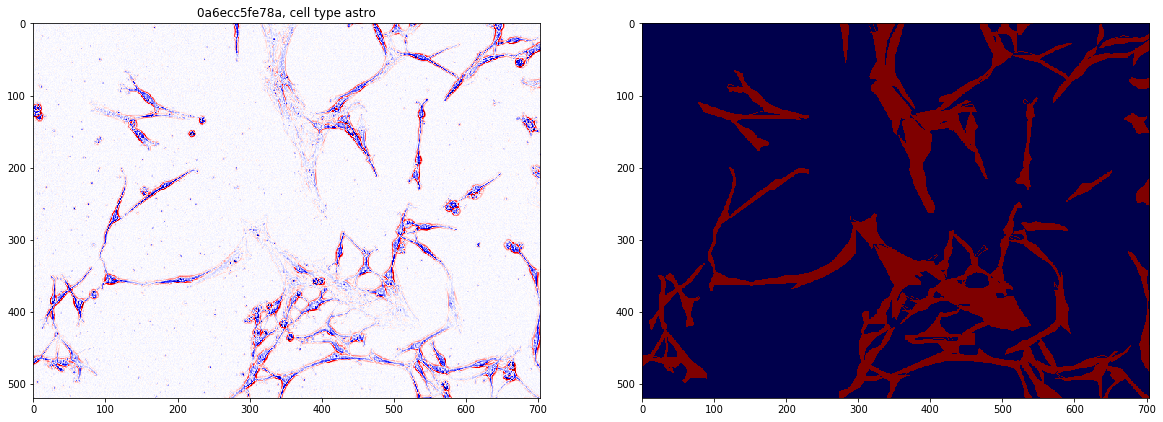

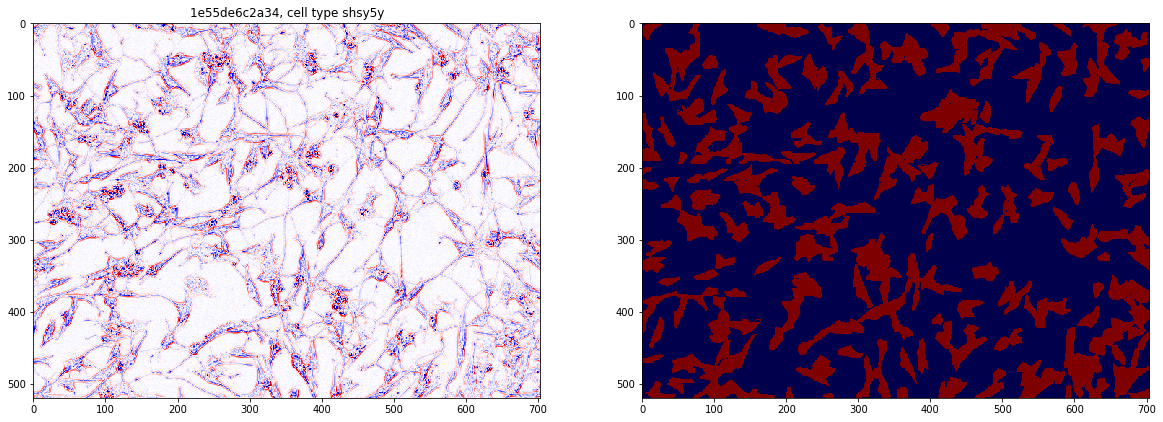

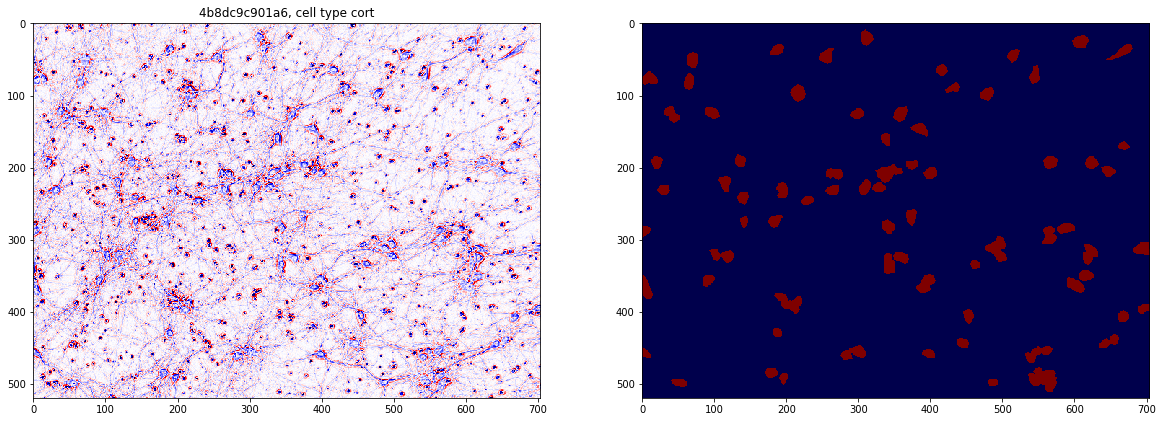

In [34]:
#list only samples in the folder
short_list = [item[:12] for item in os.listdir('data_samples/train')]

train_df_short = train_df[train_df['id'].isin(short_list)]

#plot samples with mask
cell_types2   = {}
for id,row in train_df_short.groupby(['id']):
    cell_type2 = row.cell_type.unique()[0]
    if not cell_type in cell_types2:
        cell_types2[cell_type]=[]
    cell_types2[cell_type].append(id)
    
for cell_type,ids in cell_types2.items():
    for i in sample(range(len(ids)),4):
        read_and_display(ids[i])